In [1]:
import sys
#!{sys.executable} -m pip -q install palantir fa2

In [3]:
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout
## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline
from matplotlib.pyplot import rc_context

sc.set_figure_params()
scf.set_figure_pubready()
#finally worked when using pandas 1.4

# Preprocessing pipeline from Palantir

## Load, normalize and log-transform count data

In [3]:
#counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
#counts

In [4]:
#Load adata first
data = sc.read_h5ad("/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/jupyter_notebook/data/results/scanpy_dev_cornea_1_to_17.h5ad")

In [5]:
data

AnnData object with n_obs × n_vars = 74230 × 32921
    obs: 'type', 'sample', 'time_point', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'clusters', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'cell_type_colors', 'clusters_colors', 'dendrogram_cell_type', 'dendrogram_clusters', 'doublet_info_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [6]:
Endothelium = data[data.obs['cell_type'] == 'Endothelium'] 
#Change to stroma or another

In [7]:
Endothelium

View of AnnData object with n_obs × n_vars = 643 × 32921
    obs: 'type', 'sample', 'time_point', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'clusters', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'cell_type_colors', 'clusters_colors', 'dendrogram_cell_type', 'dendrogram_clusters', 'doublet_info_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [19]:
#counts2 = sc.pp.filter_cells(counts, min_counts=1, inplace=True) #Ask Julian if this is an appropriate number for min counts

In [8]:
Endothelium = Endothelium.copy()

In [8]:
#counts2

In [22]:
#norm_df = sc.pp.normalize_total(counts, inplace=True) # exclude_highly_expressed=True

In [15]:
#We did not normalize as there was an issue with dataframe not having is.view()

#Normalizes transforms schwann to None type
#norm_df = palantir.preprocess.log_transform(Schwann)
#print(norm_df)

None


In [9]:
print(type(Endothelium))

<class 'anndata._core.anndata.AnnData'>


In [10]:
Endothelium.uns['log1p']["base"] = None
#It appears to be an error in github with highly ranked genes function: KeyError: 'base' when running tl.rank_genes_groups Github #2239
#This is the fix for now suggested in the comments of the above issue

In [11]:
#adata = sc.AnnData(Schwann) Dont need to convert to anndata??
#Changed all instances of adata to Schwann
adata = Endothelium
sc.pp.highly_variable_genes(adata, n_top_genes=250, flavor='seurat') #Changed cell_ranger to seurat for flavour
sc.pp.pca(adata) #Change n top genes to 500
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


## Run Palantir to obtain multiscale diffusion space

In [12]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=3) #Play around with eigen values to see how it affects graphs

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


## Generate embedding from the multiscale diffusion space

In [13]:
# generate neighbor draph in multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_palantir")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [14]:
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos='X_pca2d')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:01)


## Plotting results

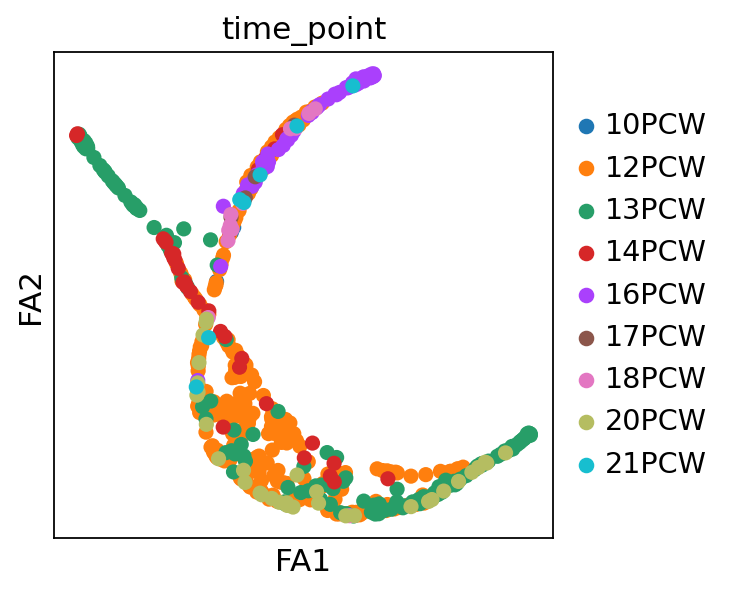

In [15]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color="time_point",color_map="RdBu_r")

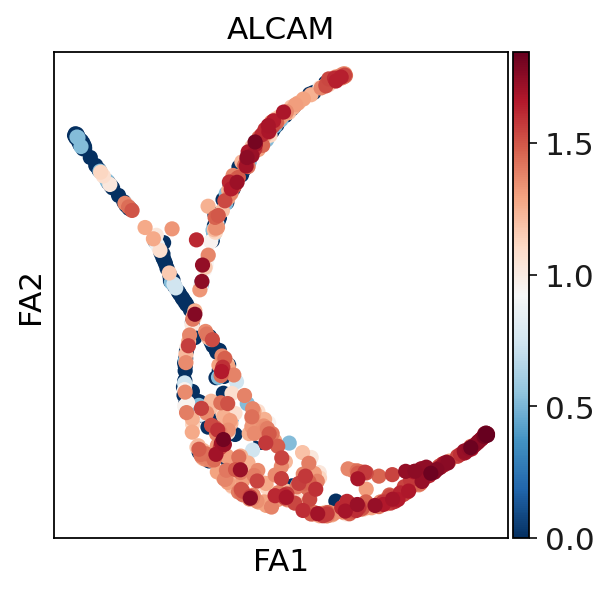

In [16]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color="ALCAM",color_map="RdBu_r")

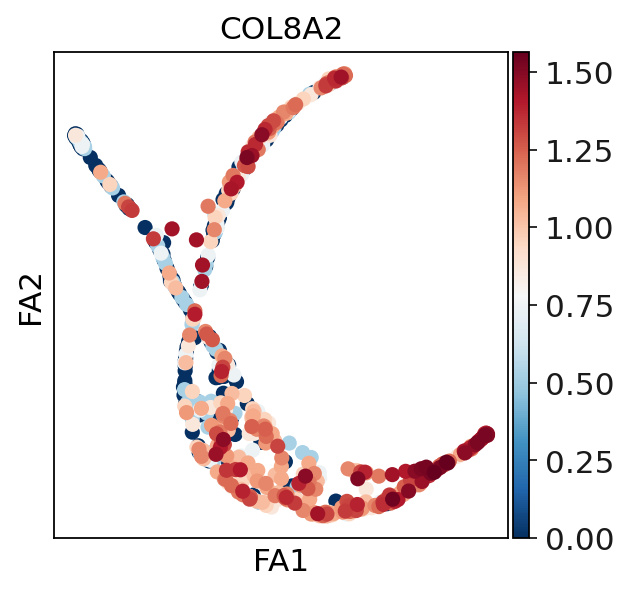

In [16]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color="COL8A2",color_map="RdBu_r")

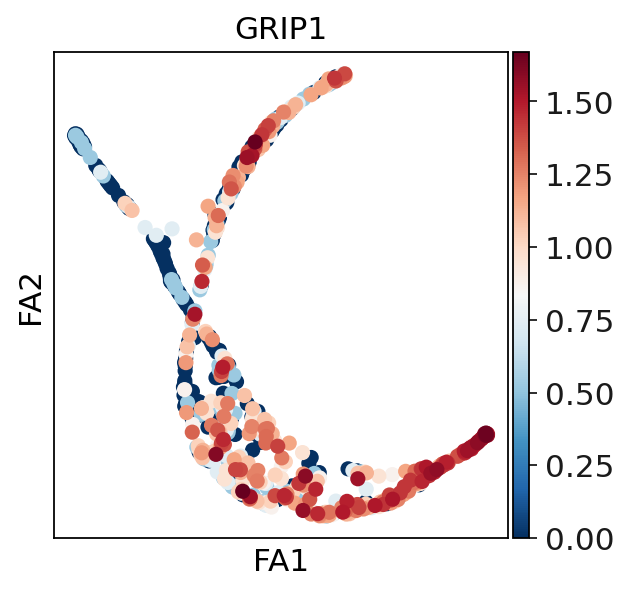

In [27]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color="GRIP1",color_map="RdBu_r")

# Tree learning with SimplePPT

In [17]:
scf.tl.tree(adata,method="ppt",Nodes=200,use_rep="palantir",
            device="cpu",seed=1,ppt_lambda=100,ppt_sigma=0.025,ppt_nsteps=200)

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.025, lambda = 100, metric = euclidean
    fitting:  55%|███████████████████████████████████▏                            | 110/200 [00:02<00:02, 43.65it/s]
    converged
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


## Projecting results onto ForceAtlas2 embedding

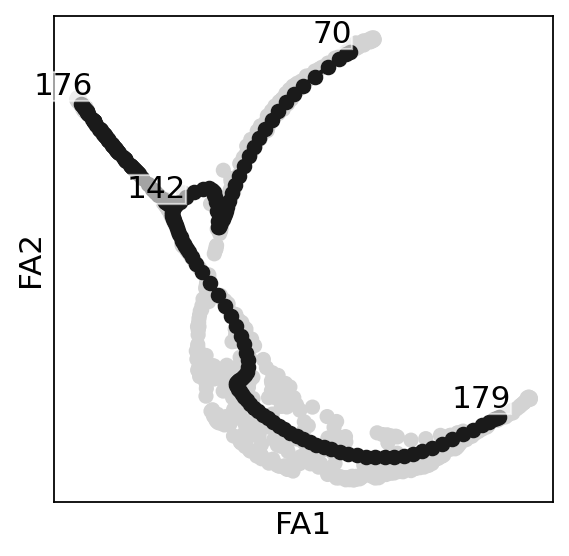

In [18]:
scf.pl.graph(adata) 

## Selecting a root and computing pseudotime

Using CD34 marker, we can confidently tell that the tip 162 is the root.

In [19]:
scf.tl.root(adata,179)

node 179 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


Here we are going to generate 100 mappings of pseudotime, to account for cell asssignment uncertainty. to .obs will be saved the mean of all calculated pseudotimes.

In [14]:
#adata.uns["graph"]["milestones"] = sorted(adata.uns["graph"]["milestones"])

In [15]:
#adata.uns["graph"]["milestones"]

In [16]:
#adata.uns["graph"]["milestones"].keys()

In [17]:
#adata.uns["graph"]["milestones"].values()

In [20]:
scf.tl.pseudotime(adata, n_jobs=1, n_map=100, seed=42) #n_jobs~cores

projecting cells onto the principal graph
    mappings: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]
    finished (0:00:59) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


# Representing the trajectory and tree

In [21]:
adata.uns['graph']['milestones']

{'142': 142, '176': 176, '179': 179, '70': 70}

On top of existing embedding

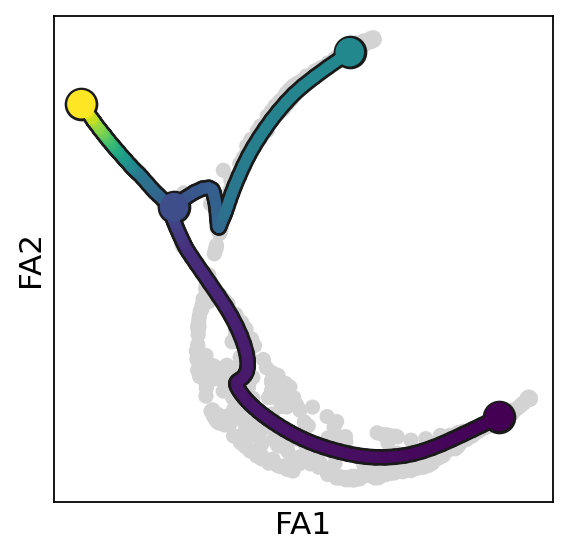

In [22]:
scf.pl.trajectory(adata)

In [26]:
#SHOULD I REORDER THE LABELS AND CHANGE TO ROOT FROM 163 ? Also the later details with milestones

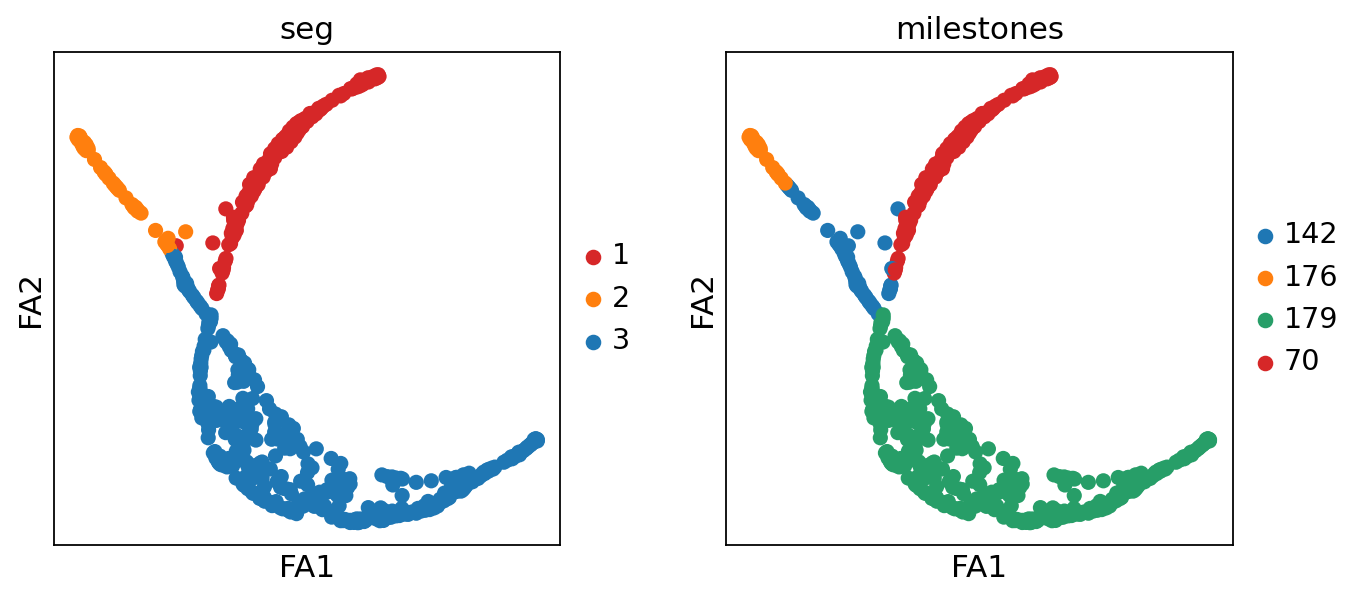

In [23]:
sc.pl.draw_graph(adata,color=["seg","milestones"])
#Look at above graph and rename the clusters in next block of code

In [24]:
scf.tl.rename_milestones(adata,["Branch","End1","Root","End2"])
#milestones
# we change the color of the root milestone for better visualisations
#adata.uns["milestones_colors"][3]="#17bece"

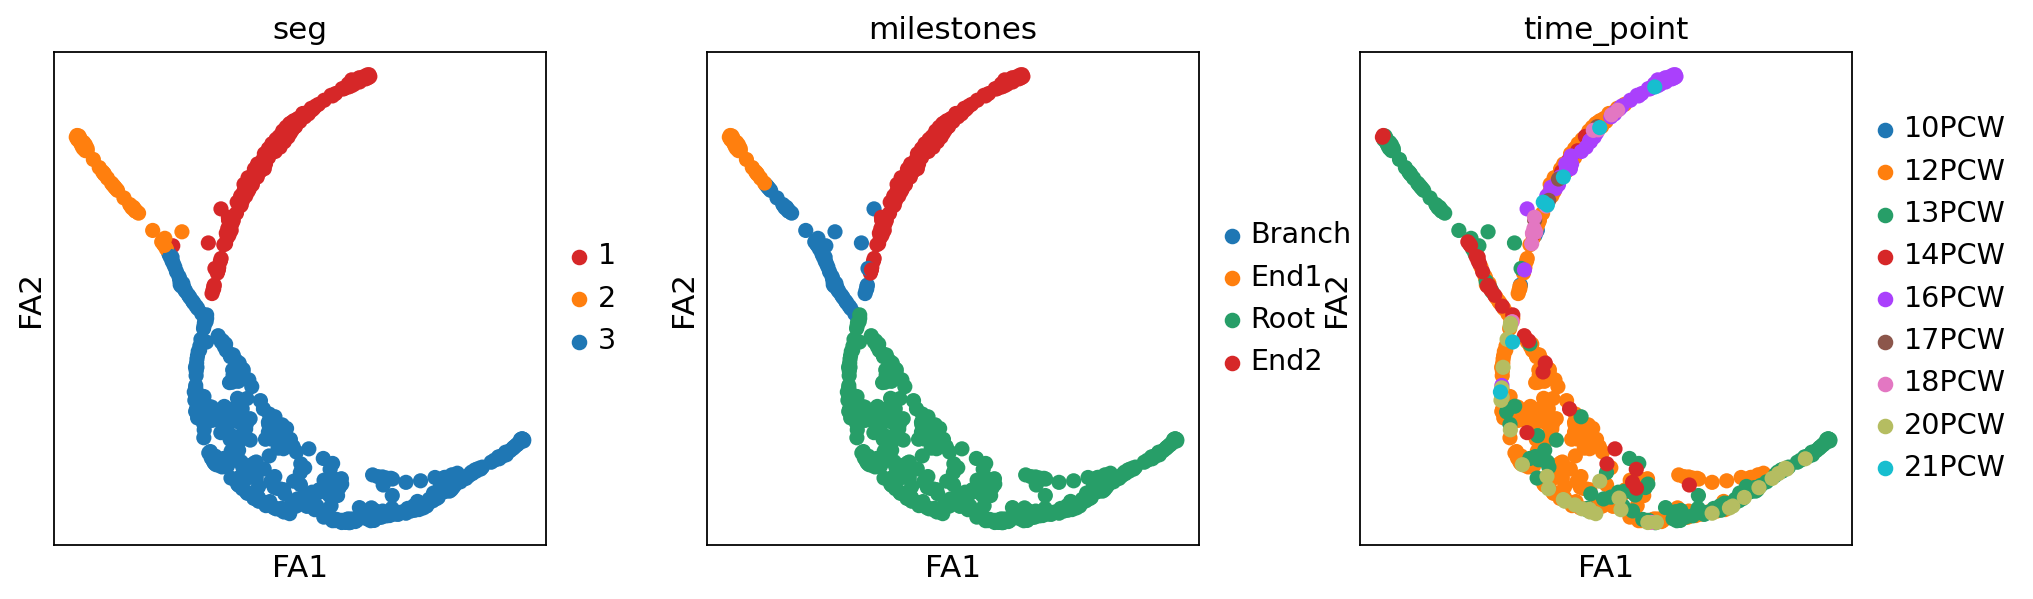

In [25]:
sc.pl.draw_graph(adata,color=["seg","milestones","time_point"])
#Should I relabel the root as an earlier timepoint or is comparing timepoint and pseudotimepoint alright like this

In [26]:
from pathlib import Path
Path("figures/").mkdir(parents=True, exist_ok=True)

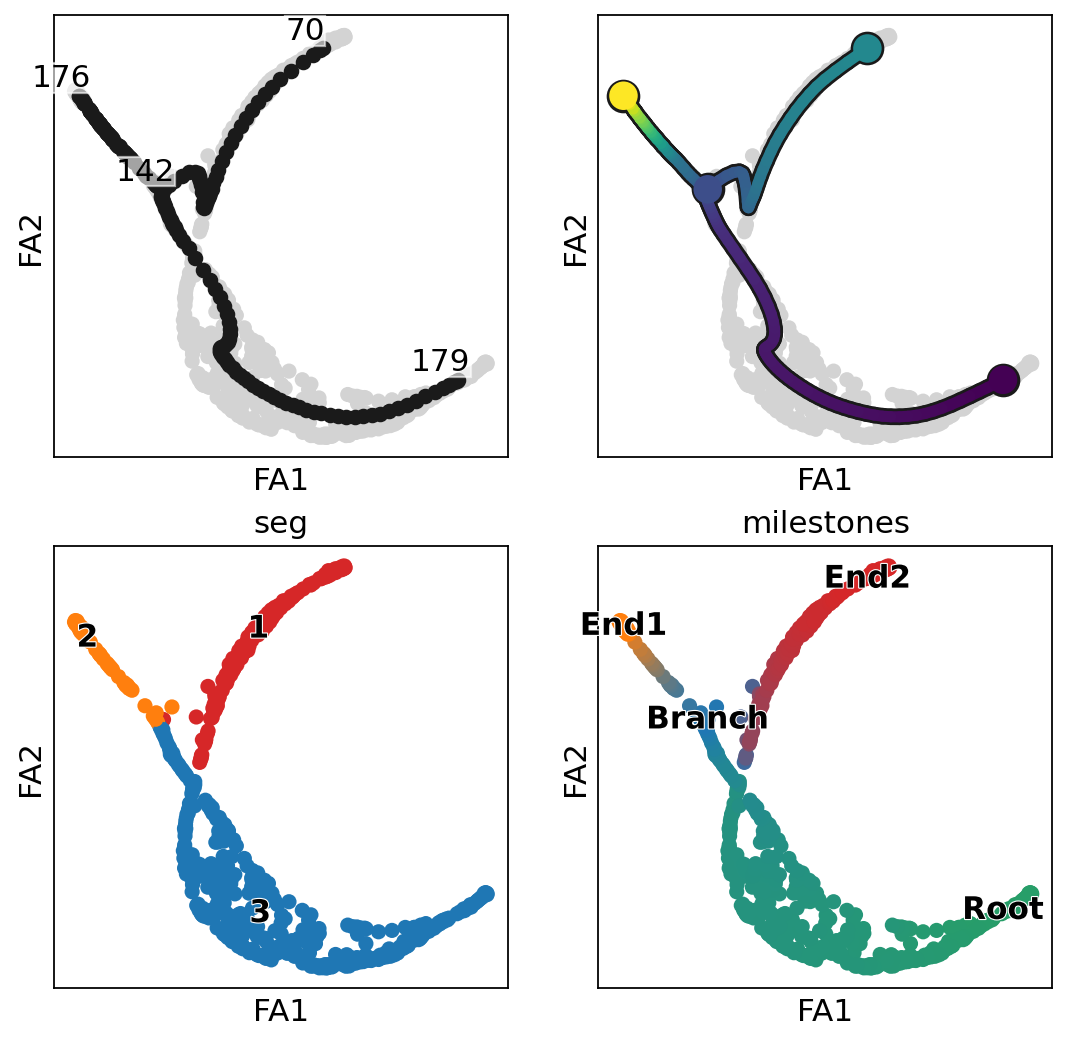

In [27]:
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(8,8))
axs=axs.ravel()
scf.pl.graph(adata,basis="draw_graph_fa",show=False,ax=axs[0])
scf.pl.trajectory(adata,basis="draw_graph_fa",show=False,ax=axs[1]) #Shows an error in this line so how do we incorporate basis
sc.pl.draw_graph(adata,color=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)
scf.pl.milestones(adata,ax=axs[3],show=False,annotate=True)
plt.savefig("figures/Endothelium_eig3.pdf",dpi=300) 

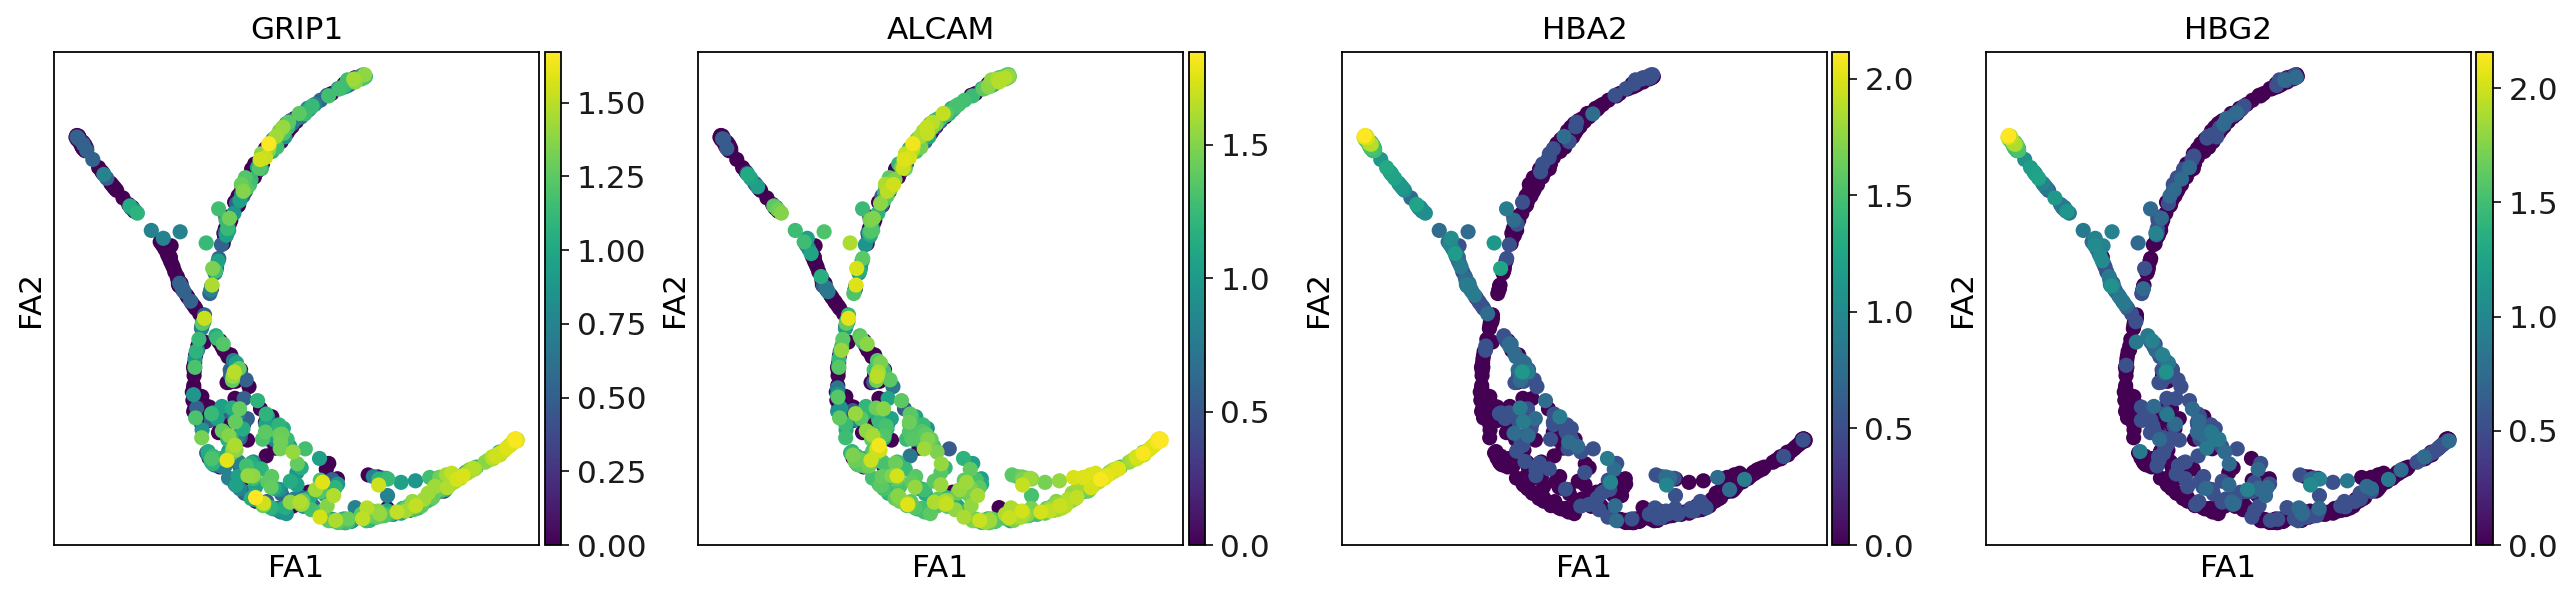

In [28]:
#For last study
colours = ['GRIP1', 'ALCAM', 'HBA2', 'HBG2']
sc.pl.draw_graph(adata, color=colours)

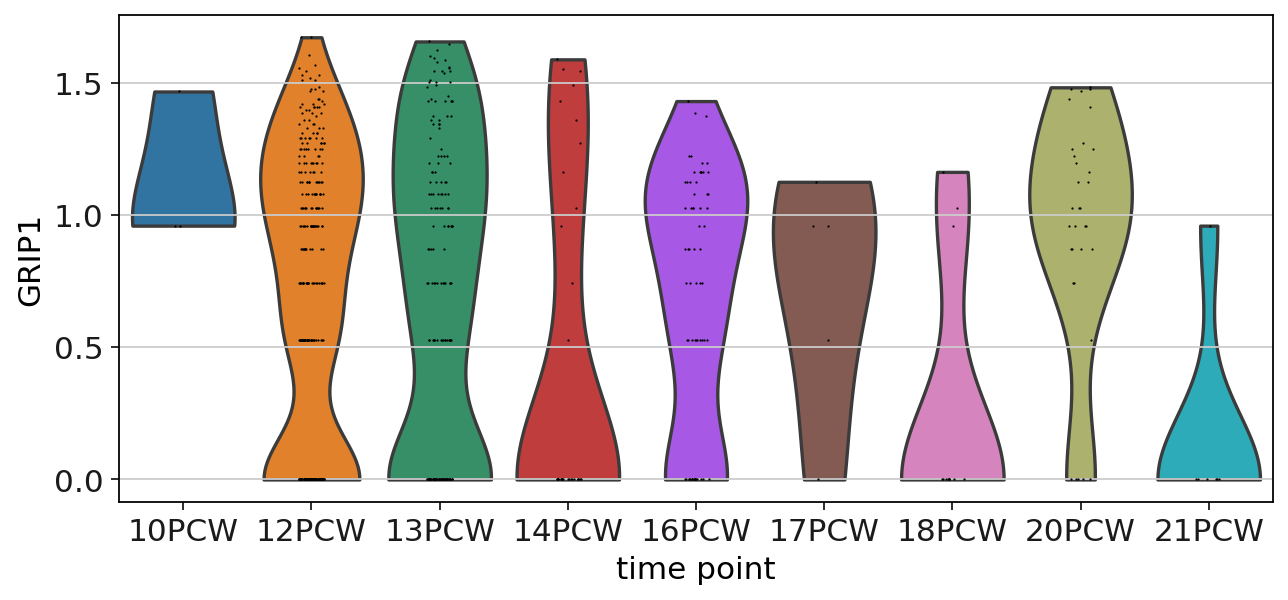

In [29]:
with rc_context({'figure.figsize': (8, 4)}):
    sc.pl.violin(adata, ['GRIP1'], groupby='time_point')

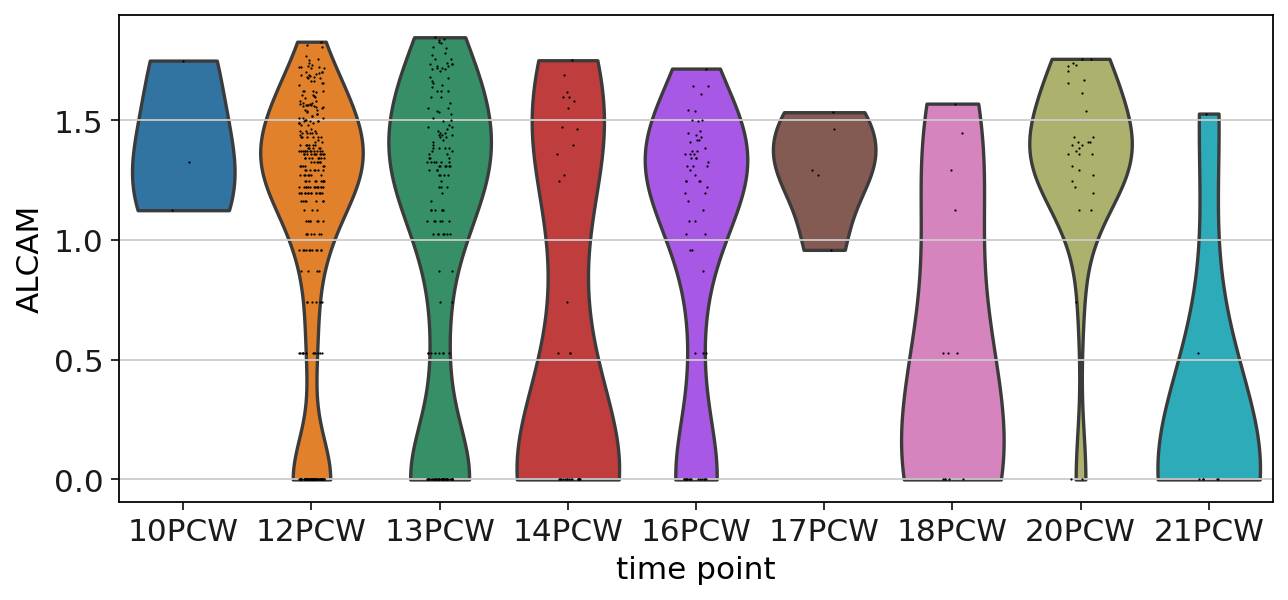

In [30]:
with rc_context({'figure.figsize': (8, 4)}):
    sc.pl.violin(adata, ['ALCAM'], groupby='time_point')

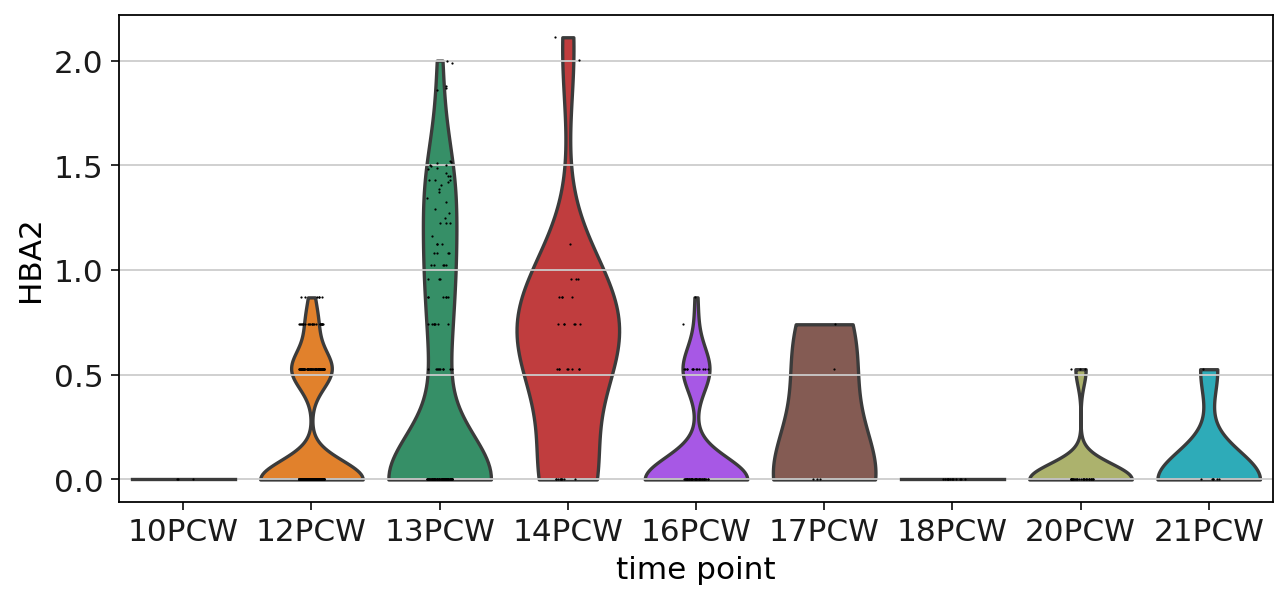

In [31]:
with rc_context({'figure.figsize': (8, 4)}):
    sc.pl.violin(adata, ['HBA2'], groupby='time_point')

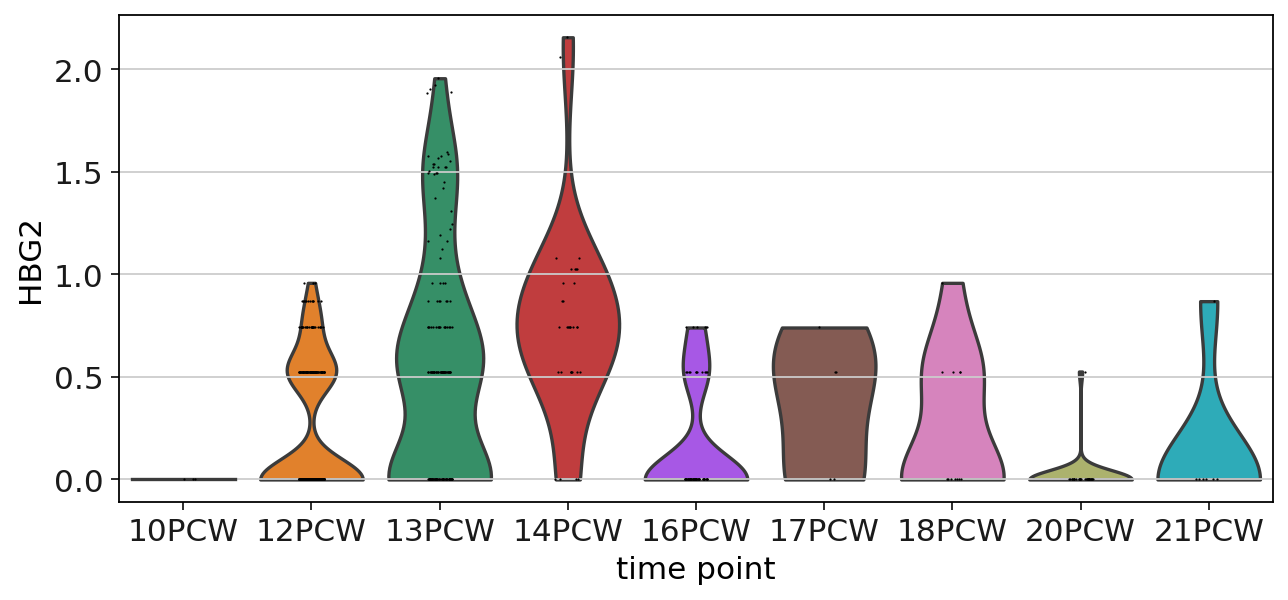

In [32]:
with rc_context({'figure.figsize': (8, 4)}):
    sc.pl.violin(adata, ['HBG2'], groupby='time_point')

## As a dendrogram representation

In [28]:
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    segment : 100%|███████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.90it/s]
    finished (0:00:00) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


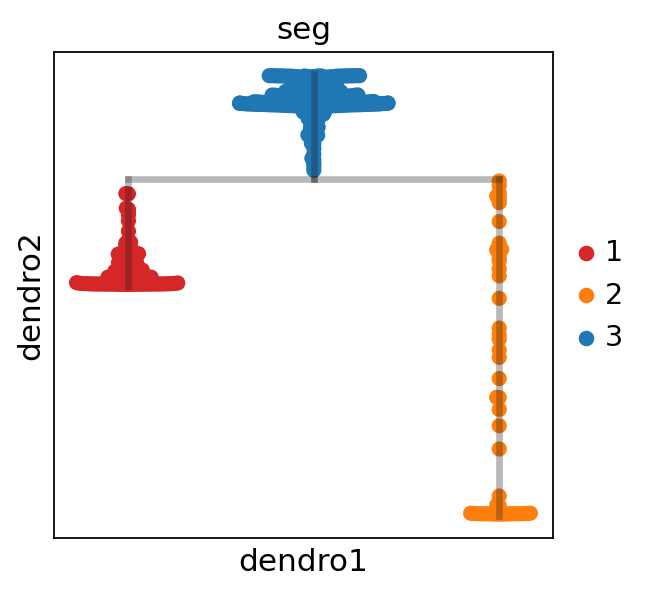

In [29]:
scf.pl.dendrogram(adata,color="seg")

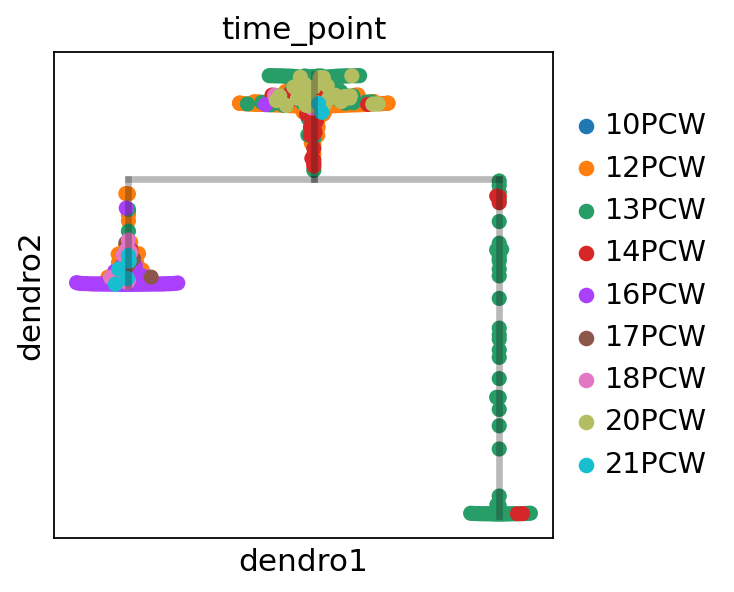

In [30]:
scf.pl.dendrogram(adata,color="time_point")
#Did i choose the root wrong if early pcw is the end point? Reroot

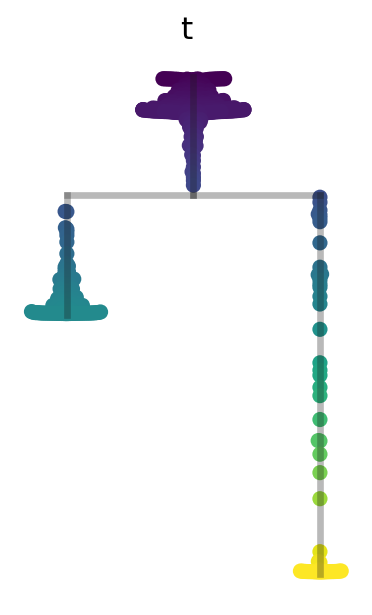

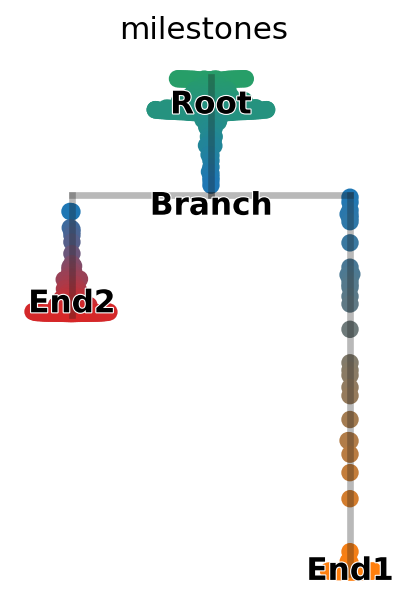

In [31]:
sc.set_figure_params(figsize=(3,4.5),frameon=False,dpi_save=300)
scf.pl.dendrogram(adata,color="t",show_info=False,save="Endothelium1_eig3.pdf",cmap="viridis")
scf.pl.dendrogram(adata,color="milestones",legend_loc="on data",color_milestones=True,legend_fontoutline=True,save="Endothelium2_eig3.pdf")

# Test and fit features associated with the tree

Let’s find out which genes are significantly changing along the tree.

In [32]:
scf.tl.test_association(adata,n_jobs=20)

test features for association with the trajectory
    single mapping : 100%|███████████████████████████████████████████████████| 32921/32921 [01:23<00:00, 394.21it/s]
    found 332 significant features (0:01:23) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


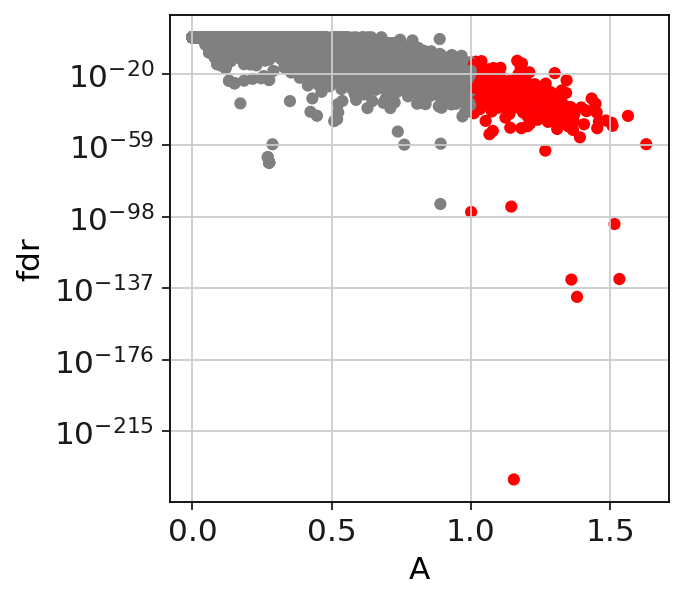

In [33]:
sc.set_figure_params()
scf.pl.test_association(adata)
plt.savefig("figures/Endothelium_eig3.pdf",dpi=300)

In [ ]:
#We can now fit the significant genes. The above looks concerning

In [34]:
scf.tl.fit(adata, n_jobs=20, save_raw=True)

fit features associated with the trajectory
    single mapping : 100%|███████████████████████████████████████████████████████| 332/332 [00:01<00:00, 279.55it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:01) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


# Plotting single features

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

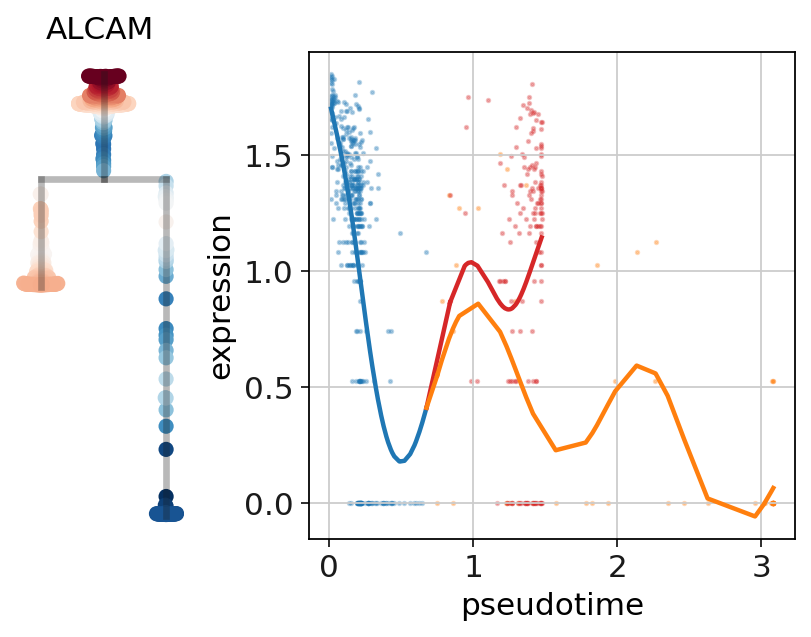

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

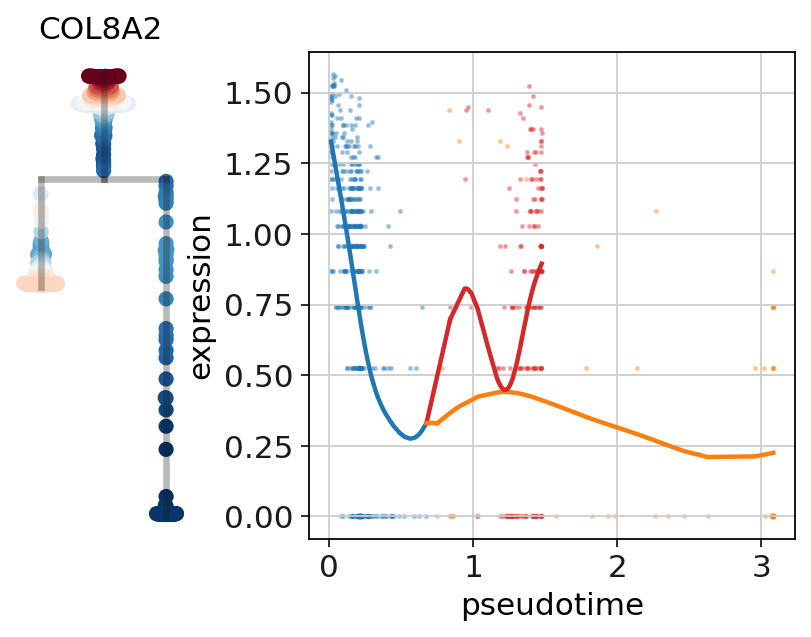

In [35]:
#Change genes according to cell type
sc.set_figure_params(figsize=(.8,4),frameon=False)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"ALCAM",basis="dendro",wspace=-.2,save="_Endothelium1_eig3.pdf")
scf.pl.single_trend(adata,"COL8A2",basis="dendro",wspace=-.2,save="_Endothelium2_eig3.pdf")

# All branches DE analysis

We are here testing for differential expression between all branches, the rescale parameter is used to considered all cells in each branch, regardless of their pseudotime:

In [36]:
scf.tl.test_fork(adata, root_milestone="Root",milestones=["End1","End2"],n_jobs=20,rescale=True) #Changed rescale to false
#originally only used Test1 and Test2
#We can keep the features which display the strongest amplitude difference:

testing fork
    single mapping
    Differential expression: 100%|███████████████████████████████████████████████| 332/332 [00:00<00:00, 657.03it/s]
    test for upregulation for each leave vs root
    upreg End2: 100%|███████████████████████████████████████████████████████████| 323/323 [00:00<00:00, 1622.79it/s]
    finished (0:00:00) --> added 
    .uns['Root->End1<>End2']['fork'], DataFrame with fork test results.


In [37]:
scf.tl.branch_specific(adata, root_milestone="Root",milestones=["End1","End2"],effect=2)

    branch specific features: 
    finished --> updated 
    .uns['Root->End1<>End2']['fork'], DataFrame updated with additionnal 'branch' column.


In [87]:
#adata.uns['Root->Test1<>Test5<>Test7'] #['fork']

{'fork': Empty DataFrame
 Columns: [Test5, Test7, Test1, de_p, fdr, signi_p, signi_fdr, up_A, up_p, branch]
 Index: []}

In [49]:
adata.obs

type sample time_point batch  n_genes_by_counts  \
CGAATTGGTATCCTTT-1-0   dev_cornea    dc1      10PCW     0               2519   
TGTAACGTCCAACTGA-1-0   dev_cornea    dc1      10PCW     0               9226   
TTACCGCGTGATGTAA-1-0   dev_cornea    dc1      10PCW     0               5115   
AAAGGTAAGCTGGCCT-1-2   dev_cornea    dc3      12PCW     2               5928   
AAAGTCCCAAGCTGTT-1-2   dev_cornea    dc3      12PCW     2               1617   
...                           ...    ...        ...   ...                ...   
CCTGCATCAACGCCCA-1-16  dev_cornea   dc17      21PCW    16               1737   
CTGCCATAGAGCTGCA-1-16  dev_cornea   dc17      21PCW    16               4020   
GTTGAACTCGAACCTA-1-16  dev_cornea   dc17      21PCW    16               2116   
TGATCAGCATACAGCT-1-16  dev_cornea   dc17      21PCW    16               1790   
TTCACGCCAAGCTCTA-1-16  dev_cornea   dc17      21PCW    16               1679   

                       total_counts  total_counts_mt  pct_counts_mt  \
CGAATTGGTATCCTTT-1-0         7956.0            299.0       3.758170   
TGTAACGTCCAACTGA-1-0        99937.0           4997.0       5.000150   
TTACCGCGTGATGTAA-1-0        23604.0            959.0       4.062871   
AAAGGTAAGCTGGCCT-1-2        23456.0            980.0       4.178036   
AAAGTCCCAAGCTGTT-1-2         5028.0             26.0       0.517104   
...                             ...              ...            ...   
CCTGCATCAACGCCCA-1-16        3879.0             90.0       2.320186   
CTGCCATAGAGCTGCA-1-16       10926.0            708.0       6.479956   
GTTGAACTCGAACCTA-1-16        6266.0            117.0       1.867220   
TGATCAGCATACAGCT-1-16        4125.0             50.0       1.212121   
TTCACGCCAAGCTCTA-1-16        3574.0             51.0       1.426973   

                       total_counts_ribo  pct_counts_ribo  ...  \
CGAATTGGTATCCTTT-1-0              2640.0        33.182507  ...   
TGTAACGTCCAACTGA-1-0             34491.0        34.512745  ...   
TTACCGCGTGATGTAA-1-0              7773.0        32.930859  ...   
AAAGGTAAGCTGGCCT-1-2              5746.0        24.496931  ...   
AAAGTCCCAAGCTGTT-1-2              1988.0        39.538582  ...   
...                                  ...              ...  ...   
CCTGCATCAACGCCCA-1-16              775.0        19.979376  ...   
CTGCCATAGAGCTGCA-1-16             1893.0        17.325645  ...   
GTTGAACTCGAACCTA-1-16             1069.0        17.060326  ...   
TGATCAGCATACAGCT-1-16              896.0        21.721212  ...   
TTCACGCCAAGCTCTA-1-16              822.0        22.999439  ...   

                       doublet_scores  predicted_doublets  doublet_info  \
CGAATTGGTATCCTTT-1-0         0.138298               False         False   
TGTAACGTCCAACTGA-1-0         0.211679               False         False   
TTACCGCGTGATGTAA-1-0         0.181818               False         False   
AAAGGTAAGCTGGCCT-1-2         0.031229               False         False   
AAAGTCCCAAGCTGTT-1-2         0.023766               False         False   
...                               ...                 ...           ...   
CCTGCATCAACGCCCA-1-16        0.039189               False         False   
CTGCCATAGAGCTGCA-1-16        0.035924               False         False   
GTTGAACTCGAACCTA-1-16        0.008333               False         False   
TGATCAGCATACAGCT-1-16        0.045161               False         False   
TTCACGCCAAGCTCTA-1-16        0.070347               False         False   

                       clusters    cell_type         t  seg    edge      t_sd  \
CGAATTGGTATCCTTT-1-0         14  Endothelium  2.887251    1   71|68  0.047635   
TGTAACGTCCAACTGA-1-0         14  Endothelium  2.853079    1  167|47  0.045145   
TTACCGCGTGATGTAA-1-0         14  Endothelium  2.895070    1   66|72  0.043419   
AAAGGTAAGCTGGCCT-1-2         14  Endothelium  2.924552    3  10|172  0.039600   
AAAGTCCCAAGCTGTT-1-2         14  Endothelium  2.825767    3  172|10  0.045489   
...                         ...    

## Displaying results using heatmap plots

In [ ]:
#same errors below, so there could be a function removing the features

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

Index(['DNAJB1', 'HSPA1B', 'KCNIP4', 'GPCPD1', 'HSPA1A', 'HSPH1', 'DDIT4',
       'C4orf3', 'CSMD1', 'HIST1H4C',
       ...
       'PFN1', 'CD81', 'MTRNR2L8', 'RPS4Y1', 'AC105402.3', 'HBA2', 'HBG1',
       'HBA1', 'HBG2', 'TAGLN'],
      dtype='object', length=332)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

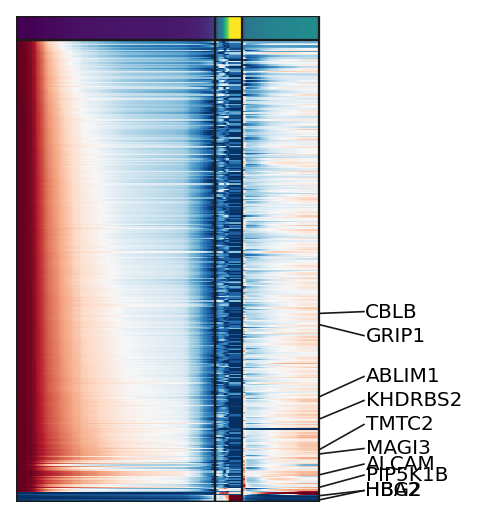

In [38]:
g1 = scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["End1","End2"],
                 #branch="End1",
                 plot_emb=False,ordering="max",return_genes=True)
g1

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

Index(['DNAJB1', 'HSPA1B', 'KCNIP4', 'GPCPD1', 'HSPA1A', 'HSPH1', 'DDIT4',
       'C4orf3', 'CSMD1', 'HIST1H4C',
       ...
       'PFN1', 'CD81', 'MTRNR2L8', 'RPS4Y1', 'AC105402.3', 'HBA2', 'HBG1',
       'HBA1', 'HBG2', 'TAGLN'],
      dtype='object', length=332)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

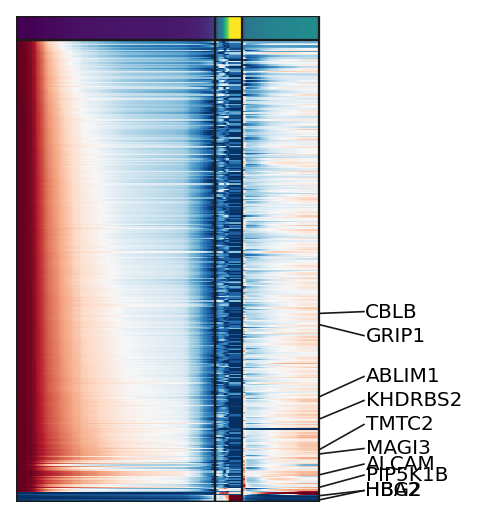

In [39]:
g2 = scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["End1","End2"],
                 #branch="End2",
                 plot_emb=False,ordering="max",return_genes=True)
g2

In [52]:
#Maybe dont include this as we removed it as a milestone branch
# g3 = scf.pl.trends(adata,
#                  root_milestone="Root",
#                  milestones=["Test1","Test2"],
#                  branch="",
#                  plot_emb=False,ordering="max",return_genes=True)
# g3

In [40]:
gg = g1.tolist()+g2.tolist() #+g3.tolist()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

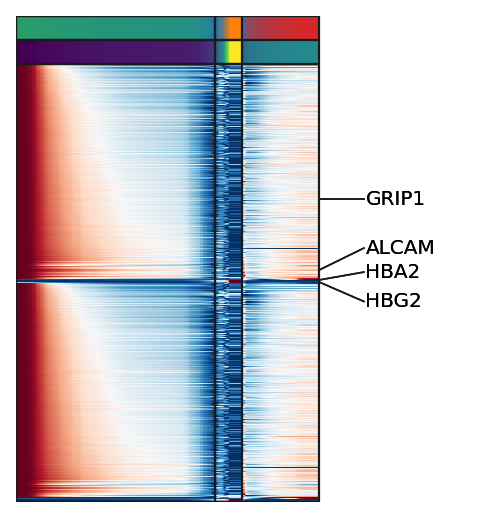

In [41]:
import matplotlib.pyplot as plt
g = scf.pl.trends(adata,gg,figsize=(4,4),annot="milestones",n_features=8,
        plot_emb=False,ordering=None,return_genes=True)
plt.savefig("figures/Endothelium_eig3.pdf",dpi=300)

## Displaying results using matrix plot

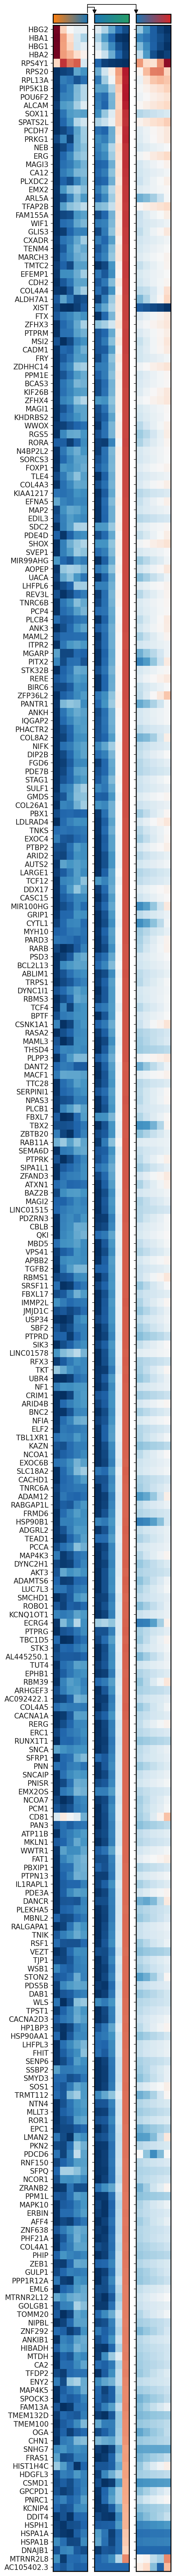

In [56]:
sc.set_figure_params()
scf.pl.matrix(adata,g2,norm="minmax",cmap="RdBu_r",colorbar=False,save="Endothelium_eig3.pdf")

# Bifurcation analysis

Let’s now focus on a specific bifurcation, where we can apply more advanced functions to detect early biasing

In [57]:
scf.tl.test_fork(adata,root_milestone="Root",milestones=["End1","End2"],n_jobs=20,rescale=True)

testing fork
    single mapping
    Differential expression: 100%|███████████████████████████████████████████████| 302/302 [00:00<00:00, 442.55it/s]
    test for upregulation for each leave vs root
    upreg End2: 100%|█████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1067.02it/s]
    finished (0:00:00) --> added 
    .uns['Root->End1<>End2']['fork'], DataFrame with fork test results.


In [58]:
scf.tl.branch_specific(adata,root_milestone="Root",milestones=["End1","End2"],effect=1.7)

    branch specific features: 
    finished --> updated 
    .uns['Root->End1<>End2']['fork'], DataFrame updated with additionnal 'branch' column.


## Early gene detection

Here we use the linear model approach to detect early genes. We test gi ~ pseudotime in the progenitor branch only to estimate if the feature displays an upward trend before the fork

In [59]:
scf.tl.activation_lm(adata,root_milestone="Root",milestones=["End1","End2"],n_jobs=20)

    single mapping
    prefork activation: 0it [00:00, ?it/s]


ValueError: Empty data passed with indices specified.

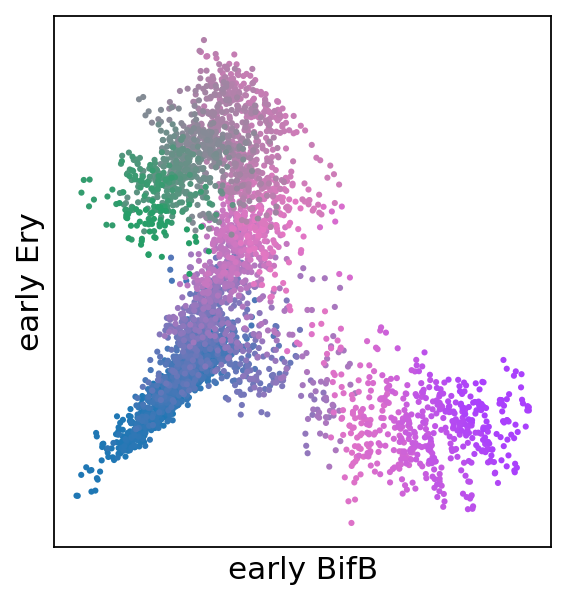

In [42]:
scf.pl.modules(adata,root_milestone="Root",milestones=["BifB","Ery"],
               smooth=True,module="early",save="_G.pdf")

# Repulsion of early gene modules

For that we need to create non-interesecting windows of cells along the tree:

In [43]:
scf.tl.slide_cells(adata,root_milestone="Root",milestones=["BifB","Ery"],win=400)

--> added 
    .uns['Root->BifB<>Ery']['cell_freq'], probability assignment of cells on 10 non intersecting windows.


In [44]:
#In each of the windows we obtain gene-gene correlation of both branch specific ealry modules.
scf.tl.slide_cors(adata,root_milestone="Root",milestones=["BifB","Ery"])

--> added 
    .uns['Root->BifB<>Ery']['corAB'], gene-gene correlation modules.


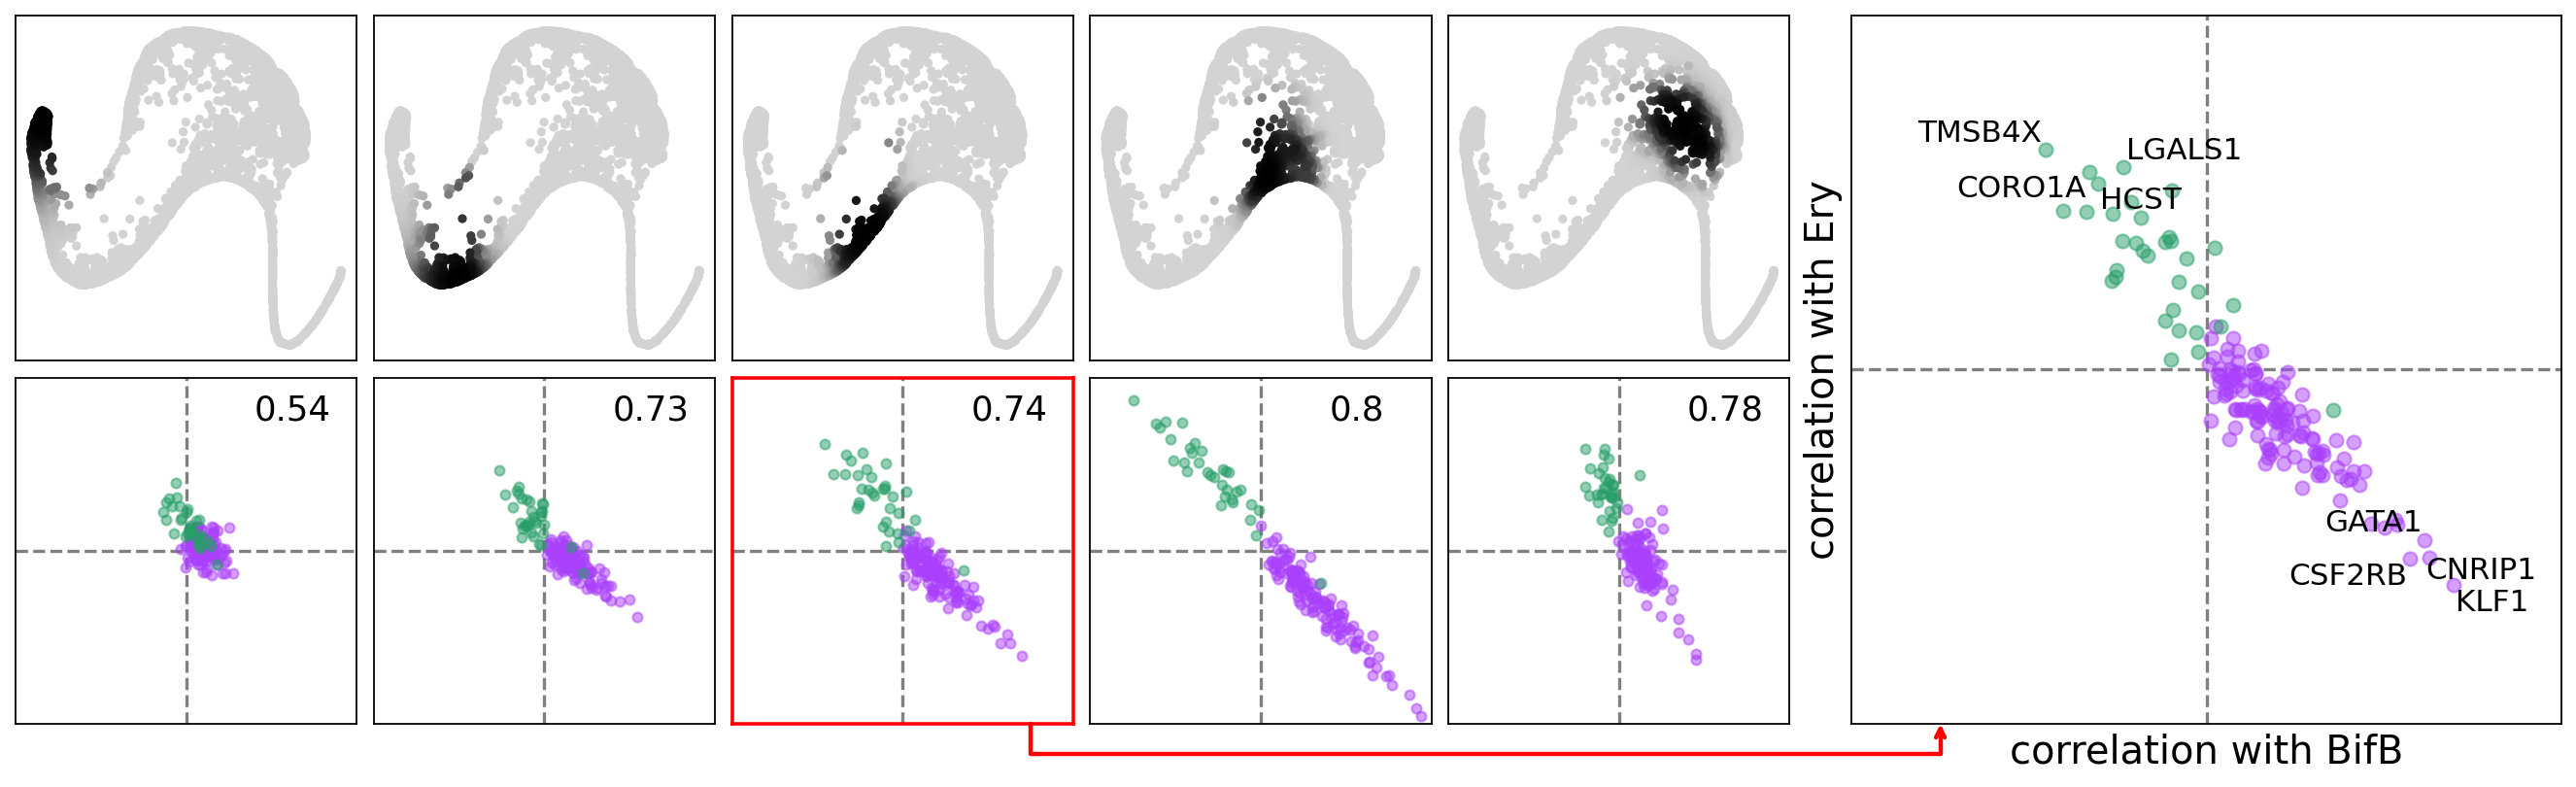

In [45]:
#Let’s plot the results:
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["BifB","Ery"],basis="draw_graph_fa",win_keep=[0,2,3,4,5],
                 focus=2,save="_H.pdf")

We can see a repulsion and mutual negative correlation prior to the bifurcation, indicating a possible competition of gene programs prior to the bifurcation.

## Local trend of module correlations

In order to investigate more precisely the competition of programs prior to bifurcation, we can compute local correlation on a sliding intersecting windows of cells:

In [46]:
scf.tl.synchro_path(adata,root_milestone="Root",milestones=["BifB","Ery"],w=100,n_map=50,n_jobs=20)

computing local correlations
    multi mapping permutations: 100%|███████████████████████████████████████████████| 50/50 [00:20<00:00,  2.42it/s]
    finished (0:00:32) --> added 
    .uns['Root->BifB<>Ery']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Root->BifB<>Ery'], GAM fit of inter-module mean local gene-gene correlations prior to bifurcation.


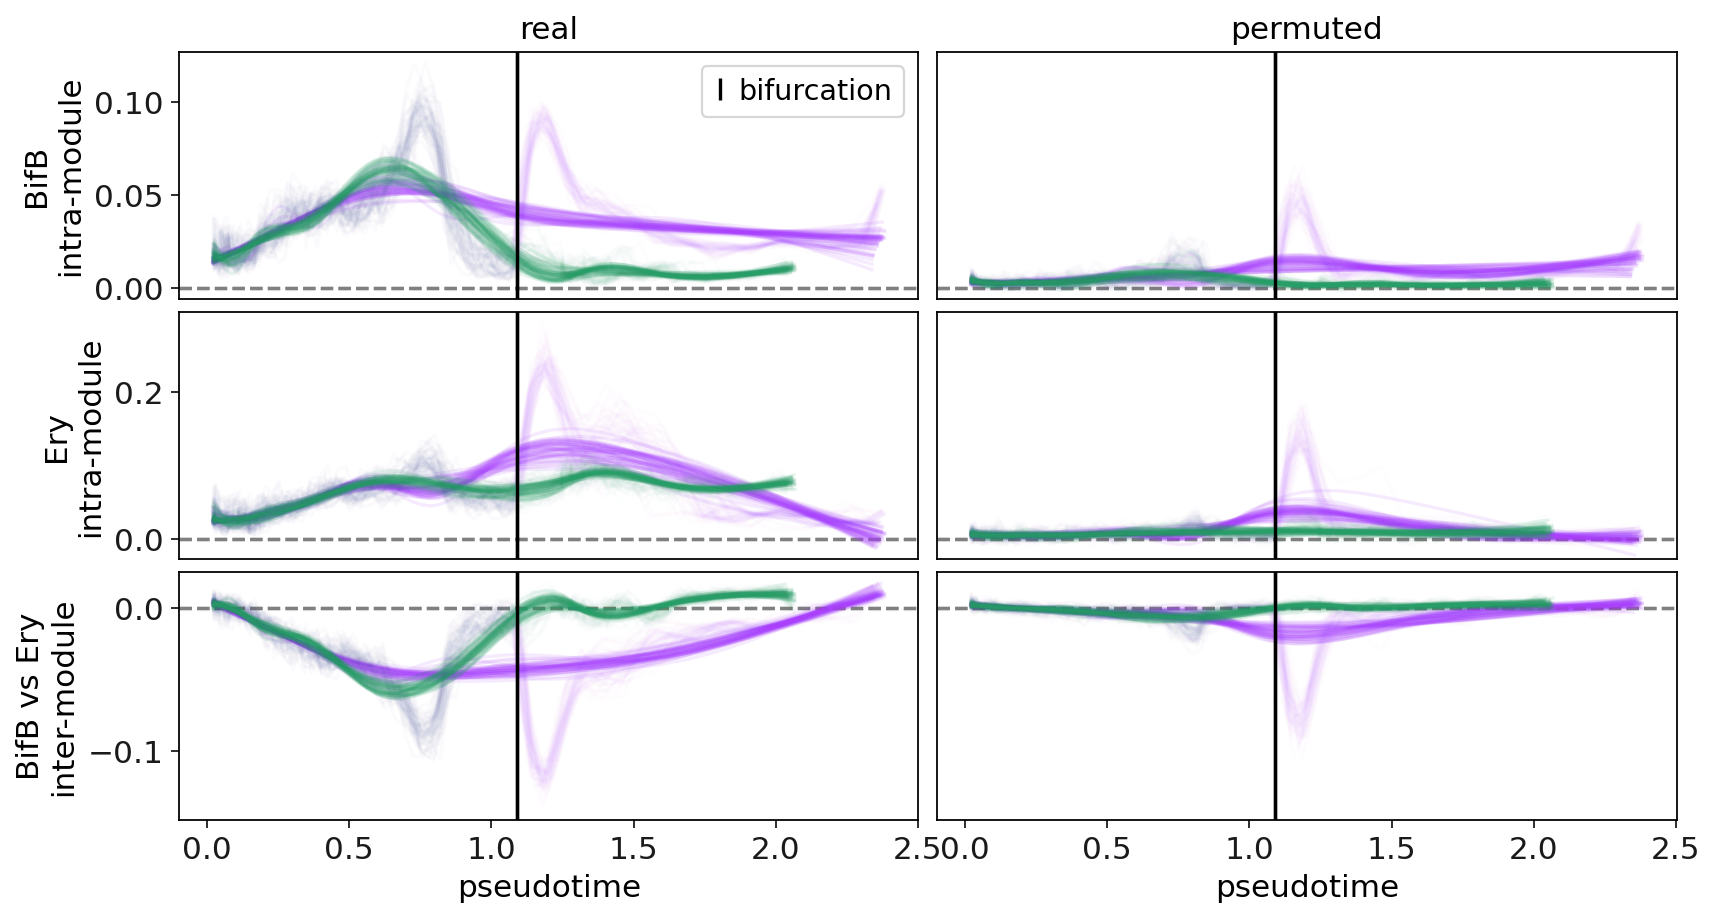

In [47]:
scf.pl.synchro_path(adata,root_milestone="Root",milestones=["BifB","Ery"],save="_I.pdf")

Here we see that negative local correlation between the two modules is present at very early pseudotime, even from the start of the trajectory! This indicates that cells are already undergoing biasing before reaching the fork.

## Formation of fate-specific modules

In order to study decision-making process prior to the tree-reconstructed bifurcation point, a framework is provided to identify the timing of gene inclusion into its module

In [48]:
scf.tl.module_inclusion(adata,root_milestone="Root",milestones=["BifB","Ery"],n_jobs=20,n_map=50,parallel_mode="mappings")

Calculating onset of features within their own module
    multi mapping: 100%|████████████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]
    finished (0:01:06) --> added 
    .uns['Root->BifB<>Ery']['module_inclusion'], milestone specific dataframes containing inclusion timing for each gene in each probabilistic cells projection.
    .uns['Root->BifB<>Ery']['fork'] has been updated with the column 'inclusion'.


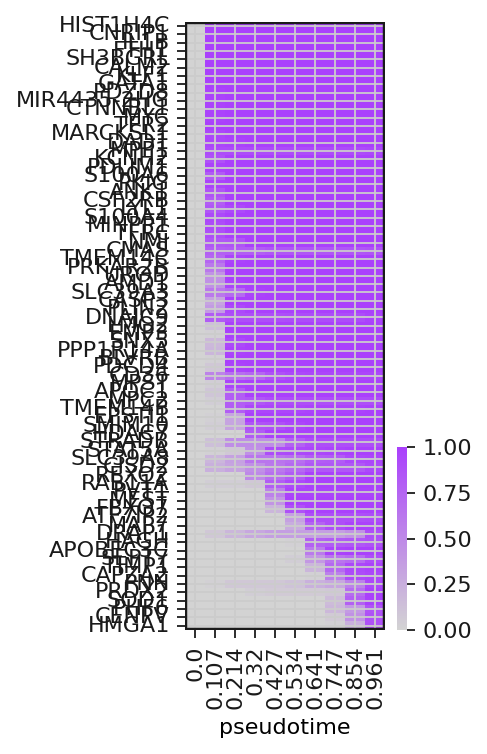

In [50]:
sc.set_figure_params(fontsize=10)
scf.pl.module_inclusion(adata,root_milestone="Root",milestones=["BifB","Ery"],
                        bins=10,branch="BifB",save="_J1.pdf",figsize=(2,5))

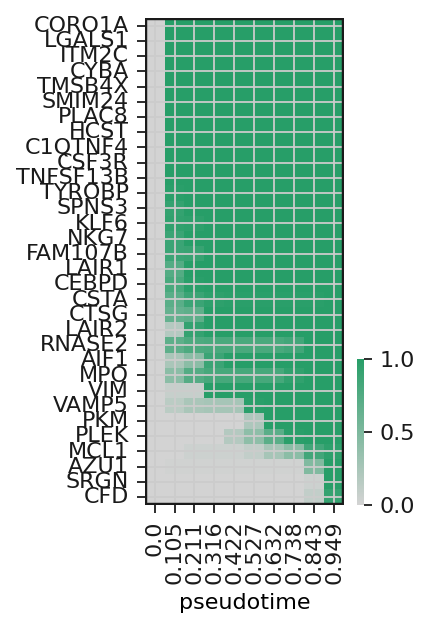

In [52]:
scf.pl.module_inclusion(adata,root_milestone="Root",milestones=["BifB","Ery"],bins=10,branch="Ery",
                       save="_J2.pdf",figsize=(2,4))

# Generating the figure

In order to generate the figure, we need to install latex compiler tectonic with Arial fonts (additionally, ImageMagick to convert PDF into image):

In [ ]:
fname="fig2_supplementary"
path="/".join(np.array(sys.executable.split("/"))[:-1])

In [ ]:
%%bash -s $fname $path
cat<<EOF >$1.tex
\documentclass{article}
\usepackage[paperheight=270mm,paperwidth=210mm]{geometry}
\geometry{left=5mm,right=5mm,top=5mm,bottom=5mm,}

\usepackage{silence}
\WarningsOff*

\usepackage[labelfont=bf]{caption}

\usepackage[rgb]{xcolor}
\usepackage{fontspec}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphicx}
\usepackage[export]{adjustbox}

\begin{document}
\setmainfont{Arial}

\noindent
\large

\fontsize{11pt}{11pt}\selectfont

\raggedright \begin{minipage}[!ht]{0.67\textwidth}
\raggedright \begin{minipage}[t]{0.6\textwidth}
\vspace{0cm}
\textbf{A}\\

\includegraphics[width=\textwidth]{figures/A.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[t]{0.11\textwidth}
\vspace{0cm}
\textbf{B}\\
\includegraphics[width=\textwidth]{figures/dendrogramB1.pdf}
\includegraphics[width=\textwidth]{figures/dendrogramB2.pdf}
\end{minipage}
\raggedright \begin{minipage}[t]{0.27\textwidth}
\vspace{0cm}
\textbf{C}\\
\includegraphics[width=\textwidth]{figures/C.pdf}

\textbf{D}\\
\includegraphics[width=\textwidth]{figures/D.pdf}
\end{minipage}

\textbf{E}\\

\raggedright \begin{minipage}[!ht]{0.5\textwidth}
\includegraphics[width=\textwidth]{figures/single_trend_E1.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.5\textwidth}
\includegraphics[width=\textwidth]{figures/single_trend_E2.pdf}
\end{minipage}\hfill
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.315\textwidth}
\vspace{0cm}
\begin{minipage}[t]{\textwidth}
\vspace{0cm}
\textbf{F}\\

\includegraphics[width=\textwidth]{figures/matrix_F.pdf}
\end{minipage}\hfill
\end{minipage}
\hfill


\raggedright \begin{minipage}[t]{0.22\textwidth}
\raggedright \textbf{G}\\
\includegraphics[width=\textwidth]{figures/modules_G.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[t]{0.78\textwidth}
\raggedright \textbf{H}\\
\includegraphics[width=\textwidth]{figures/slide_cors_H.pdf}
\end{minipage}\hfill

\raggedright \begin{minipage}[t]{0.59\textwidth}
\vspace{0cm}
\textbf{I}\\

\includegraphics[width=\textwidth]{figures/synchro_path_I.pdf}
\end{minipage}\hfill
\begin{minipage}[t]{0.41\textwidth}
\vspace{0cm}
\textbf{J}\\

\raggedright \begin{minipage}[!ht]{0.47\textwidth}
\includegraphics[width=\textwidth]{figures/module_inclusion_J1.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.5\textwidth}
\includegraphics[width=\textwidth]{figures/module_inclusion_J2.pdf}
\end{minipage}\hfill
\end{minipage}
\hfill

\clearpage
EOF
echo "\end{document}" >> $1.tex

$2/tectonic -c minimal $1.tex

$2/identify $1.pdf

$2/convert -flatten -density 300 $1.pdf $1.jpg

In [ ]:
from IPython.display import Image
Image(filename=f'{fname}.jpg')